In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import SRW_v044 as SRW
from scipy.sparse import csr_matrix, csc_matrix, issparse
import functools
from base_network import make_network

In [3]:
nsamples = 100
nnodes = 1000
edge_freq = 0.004
cliq_edge_freq = 0.114
hi_mut_freq = 0.5
hi_node = nnodes*3/4
group_labels = ['Subtype 1']*(nsamples//2) + ['Subtype 2']*(nsamples//2)
feature_names = ['Subnetwork 1', 'Subnetwork 2', 'High mut source', 'High mut target', 
                 'Random 1', 'Random 2', 
                 'Self loop', 'Intercept']
node_names = ['{}'.format(i) for i in range(1,nnodes+1)]
sample_names = ['{}'.format(i) for i in range(1,nsamples+1)]

rand_mut_freq = 0.015

In [4]:
rst_prob = 0.3
lam = 1e-1
WMW_b = 2e-4

In [ ]:
network_type = 'random' # 'random', 'scale_free', 'small_world', 'cliq_random'
edges, features = make_network(network_type, nnodes, edge_freq, cliq_edge_freq)

P_init = []
for p in range(nsamples):
    p_init = []
    for i in range(nnodes):
        freq=0
        if p == i:
            freq = 1
        elif i == hi_node:
            freq = hi_mut_freq
        elif i<100:
            if (max(p,i)<50 or min(p,i)>=50):
                freq = 0.015
            else:
                freq = 0.000
        else:
            freq = rand_mut_freq

        if np.random.random() < freq:
            p_init.append(1)
        else:
            p_init.append(0)

    P_init.append(p_init)
P_init = csr_matrix(P_init)

SRW_obj = SRW.SRW_solver(edges, features, nnodes, P_init, rst_prob, group_labels, lam, w_init_sd=0.01, 
                         w=None, feature_names=feature_names, sample_names=sample_names, 
                         node_names=node_names, loss='WMW', norm_type='L1', learning_rate=0.5, 
                         update_w_func='Adam', P_init_val=P_init, group_labels_val=group_labels, 
                         ncpus=len(feature_names), maxit=1000, early_stop=10, WMW_b=WMW_b)
SRW_obj.train_SRW_GD()

finished calculating strength_grad: 11:01:08
finished network propagation: 11:01:09


In [55]:
SRW_obj.w_map

,Weight
Subnetwork 1,8.178438
Subnetwork 2,8.490222
High mut source,0.004118
High mut target,-0.063055
Random 1,4.047448
Random 2,-2.219268
Self loop,-2.293991
Intercept,-13.409882


In [56]:
import numpy as np
import pyNBS
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [63]:
SRW_obj.w = SRW_obj.w_list[0]
SRW_obj.map_w()
SRW_obj.w[-1] = 100
SRW_obj.w[-2] = -200
SRW_obj.Q = SRW.generate_Q(SRW_obj.edges, SRW_obj.nnodes, SRW_obj.features, SRW_obj.w)
P = SRW.iterative_PPR(SRW_obj.Q.toarray(), SRW.renorm(SRW_obj.P_init).toarray(), SRW_obj.rst_prob)
SRW_obj.C = SRW_obj.centroid(P, SRW_obj.ngroups, SRW_obj.group2indeces_list)
SRW_obj.calc_cost_and_acc_val()
SRW_obj.generate_Q_and_P_fin()

In [58]:
P_df = SRW_obj.P_fin_df.copy()
P_df_pca, pca_components, explained_variance_ratio = pyNBS.run_pca(P_df)

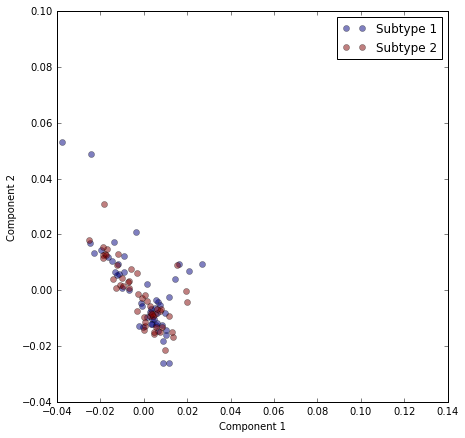

In [59]:
X = P_df_pca.copy()
X['labels'] = group_labels

labels = X.groupby('labels')

cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0, 1.0, len(labels)))

fig, ax = plt.subplots(figsize=(7, 7))
ax.set_color_cycle(colors)
for name, label in labels:
    ax.plot(label.PC1, label.PC2, alpha=0.5, marker='o', linestyle='', label=name)

plt.xlabel('Component 1')
plt.ylabel('Component 2')
ax.legend(loc='upper right')

plt.savefig('data/sim1001000_0_PCA.pdf')
plt.show()

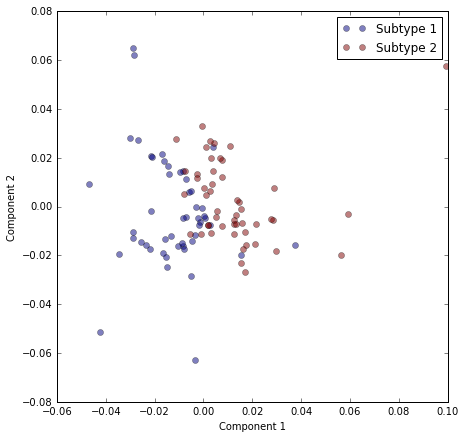

In [64]:
SRW_obj.w = SRW_obj.w_list[-1]
SRW_obj.map_w()
SRW_obj.Q = SRW.generate_Q(SRW_obj.edges, SRW_obj.nnodes, SRW_obj.features, SRW_obj.w)
P = SRW.iterative_PPR(SRW_obj.Q.toarray(), SRW.renorm(SRW_obj.P_init).toarray(), SRW_obj.rst_prob)
SRW_obj.C = SRW_obj.centroid(P, SRW_obj.ngroups, SRW_obj.group2indeces_list)
SRW_obj.calc_cost_and_acc_val()
SRW_obj.generate_Q_and_P_fin()

P_df = SRW_obj.P_fin_df.copy()
P_df_pca, pca_components, explained_variance_ratio = pyNBS.run_pca(P_df)

X = P_df_pca.copy()
X['labels'] = group_labels

labels = X.groupby('labels')

cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0, 1.0, len(labels)))

fig, ax = plt.subplots(figsize=(7, 7))
ax.set_color_cycle(colors)
for name, label in labels:
    ax.plot(label.PC1, label.PC2, alpha=0.5, marker='o', linestyle='', label=name)

plt.xlabel('Component 1')
plt.ylabel('Component 2')
ax.legend(loc='upper right')

plt.savefig('data/sim1001000_-1_PCA.pdf')

plt.show()

In [61]:
P_df

,1,2,3,4,5,6,7,8,9,10,...,991,992,993,994,995,996,997,998,999,1000
1,0.022336,0.003366,0.000658,0.003904,0.005009,0.006132,0.000433,0.018003,0.001205,0.000272,...,0.000029,0.000018,0.000220,0.000062,0.000049,0.000298,0.001272,0.000226,0.000062,0.000021
2,0.007230,0.028185,0.000568,0.007266,0.003778,0.000669,0.000290,0.027125,0.001401,0.001301,...,0.003292,0.000046,0.013751,0.000009,0.000026,0.000244,0.000022,0.000098,0.000658,0.000004
3,0.001071,0.001344,0.018573,0.001056,0.005287,0.002816,0.000740,0.003747,0.001072,0.000193,...,0.000012,0.000123,0.000161,0.000945,0.000012,0.000074,0.000103,0.000815,0.017987,0.000075
4,0.013180,0.006648,0.002626,0.020802,0.010672,0.000119,0.000589,0.005663,0.001025,0.000347,...,0.000046,0.000002,0.000222,0.000019,0.000465,0.000248,0.000026,0.000266,0.000123,0.000015
5,0.004973,0.013154,0.002793,0.004273,0.034344,0.000574,0.002421,0.010424,0.003986,0.000971,...,0.000008,0.000004,0.000080,0.000007,0.000002,0.003872,0.000194,0.001806,0.000012,0.000415
6,0.012969,0.004777,0.002519,0.004417,0.013402,0.023559,0.001255,0.019894,0.003746,0.000310,...,0.000014,0.000123,0.000291,0.000246,0.000016,0.000064,0.000020,0.000060,0.000007,0.003964
7,0.006080,0.005376,0.001181,0.011406,0.001686,0.000167,0.034880,0.005497,0.001331,0.000318,...,0.000180,0.000001,0.002152,0.000017,0.000003,0.000063,0.000193,0.000065,0.000027,0.000031
8,0.002459,0.003673,0.000387,0.003769,0.003270,0.001157,0.001038,0.019516,0.001023,0.000270,...,0.000660,0.000007,0.000317,0.000049,0.000102,0.005928,0.001153,0.001425,0.000008,0.000143
9,0.001773,0.001556,0.002409,0.001311,0.005536,0.000761,0.001174,0.002609,0.021367,0.000270,...,0.000022,0.000035,0.000648,0.000201,0.000002,0.000068,0.000151,0.000312,0.000011,0.000049
10,0.002845,0.005098,0.000447,0.004184,0.003415,0.002448,0.000754,0.017151,0.000970,0.021524,...,0.000051,0.000008,0.001850,0.000038,0.000017,0.018284,0.000277,0.000048,0.000019,0.000056


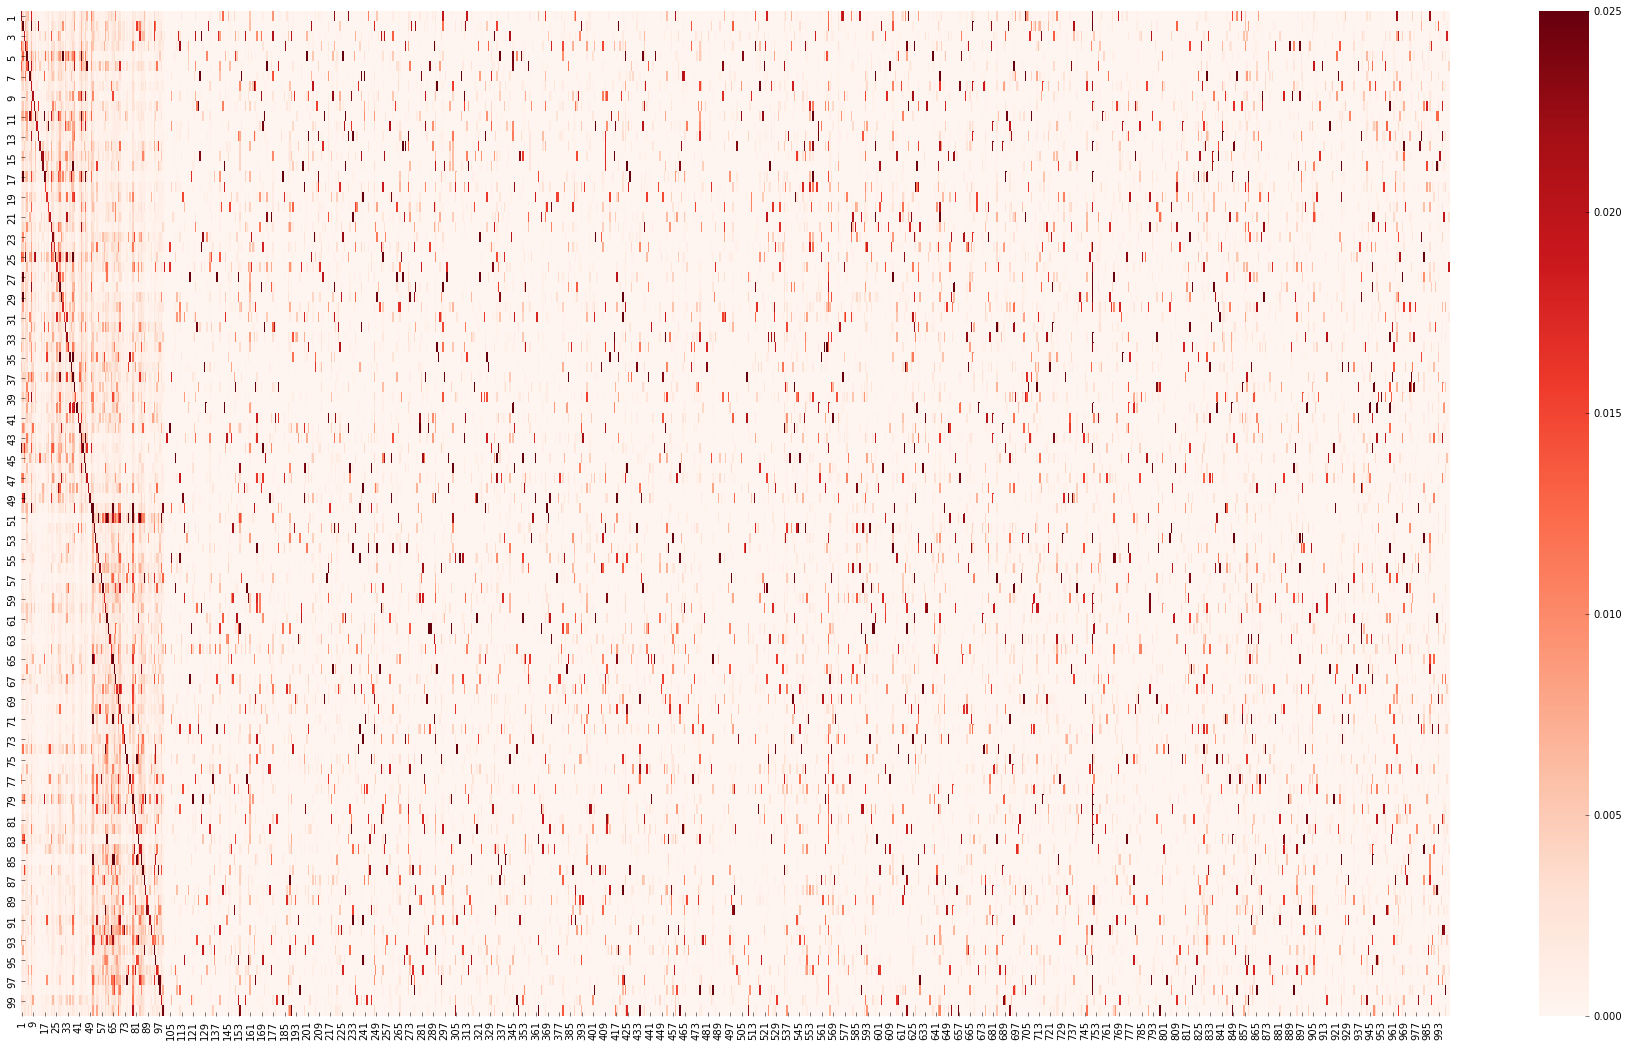

In [62]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(32,18))
ax = sns.heatmap(P_df.clip(upper=0.025),cmap='Reds', square=False)
plt.savefig('data/sim1001000_P_df.pdf')